<a href="https://colab.research.google.com/github/cs449w23/project-cs_get_degrees/blob/main/CNN_rodney.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from collections import defaultdict
from torch.utils.data import Dataset, random_split, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.image as mpimg
from torch.utils.data import DataLoader
import time
import h5py

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #self.linear_layer_size = linear_layer_size
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3)  # input: torch.Size([64, 3, 96, 96])
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3) # input: torch.Size([64, 16, 47, 47])
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3) # input: torch.Size([64, 32, 22, 22])
        self.conv4 = torch.nn.Conv2d(64, 128, kernel_size=3) # input: torch.Size([64, 64, 10, 10])
        # output: torch.Size([64, 128, 4, 4])
        

    def forward(self, x):
        #print(x.shape)
        batch_size = x.size(0)

        relu = torch.nn.ReLU()
        maxpool = torch.nn.MaxPool2d(stride=2,kernel_size=2)
        x = self.conv1(x)
        x = maxpool(relu(x))
        #print(x.shape)
        x = self.conv2(x)
        x = maxpool(relu(x))
        #print(x.shape)
        x = self.conv3(x)
        x = maxpool(relu(x))
        #print(x.shape)
        x = self.conv4(x)
        x = maxpool(relu(x))
        #print(x.shape)
        # x = x.reshape(batch_size, self.linear_layer_size)
        # x = self.linear(x)
        return x

In [ ]:
class FC(torch.nn.Module):
    def __init__(self):
          super(FC, self).__init__()
          self.fc1 = torch.nn.Linear(4 * 4 * 128, 1)  # input: (6,6,128) # output 2 classes
          self.actv = torch.nn.Sigmoid()
    def forward(self, x):
        #print(x.shape)
        batch_size = x.size(0)
        x = torch.flatten(x, 1)
        #print(x.shape)
        x = self.fc1(x)
        x = self.actv(x)
        return x


In [ ]:
class LSTM(torch.nn.Module):
    def __init__(self,batch_size=32):
        super(LSTM,self).__init__()
        self.input_size = 128
        self.output_size = 2
        self.hidden_size = 32
        self.n_layers = 1
        self.batch_size = batch_size
        self.lstm = torch.nn.LSTM(input_size=self.input_size,hidden_size=self.hidden_size,num_layers=self.n_layers,batch_first=True)
        self.fc1 = torch.nn.Linear(in_features=5,out_features=self.output_size)

    def forward(self,x):
        output,_status = self.lstm(x)
        output = output.view(-1, self.hidden_size)
        output = self.fc1(torch.relu(output))
        return output

    def initHidden(self):
        return torch.zeros(self.n_layers,self.batch_size, self.hidden_size)


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
batch_size = 32

In [ ]:
split_test = 75_000
with h5py.File("/kaggle/input/metastatic-tissue-classification-patchcamelyon/pcam/training_split.h5", "r") as f:
    train_data_x = f['x']
    train_data_x_small = torch.from_numpy(train_data_x[:split_test]).permute(0,3,1,2).float()
    print(train_data_x_small.shape)
with h5py.File("/kaggle/input/metastatic-tissue-classification-patchcamelyon/Labels/Labels/camelyonpatch_level_2_split_train_y.h5", "r") as f:
    train_data_y = f['y']
    train_data_y_small = torch.from_numpy(train_data_y[:split_test]).float()


train_data_small = TensorDataset(train_data_x_small, train_data_y_small)


torch.Size([75000, 3, 96, 96])


In [ ]:
split_val = 7_500
with h5py.File("/kaggle/input/metastatic-tissue-classification-patchcamelyon/pcam/validation_split.h5", "r") as f:
    val_data_x = f['x']
    val_data_x_small = torch.from_numpy(val_data_x[:split_val]).float().permute(0,3,1,2).float()
    print(val_data_x_small.shape)
with h5py.File("/kaggle/input/metastatic-tissue-classification-patchcamelyon/Labels/Labels/camelyonpatch_level_2_split_valid_y.h5", "r") as f:
    val_data_y = f['y']
    val_data_y_small = torch.from_numpy(val_data_y[:split_val]).float()
    
    
val_data_small = TensorDataset(val_data_x_small, val_data_y_small)

torch.Size([7500, 3, 96, 96])


torch.Size([3, 96, 96])
torch.Size([3, 96, 96])
torch.Size([3, 96, 96])
torch.Size([3, 96, 96])
torch.Size([3, 96, 96])
torch.Size([3, 96, 96])
torch.Size([3, 96, 96])
torch.Size([3, 96, 96])
torch.Size([3, 96, 96])


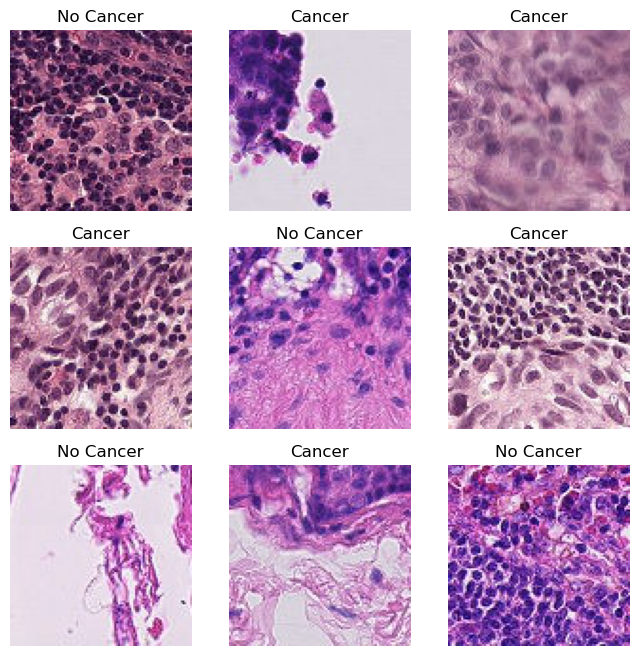

In [ ]:
# Data needs to be int for this to rint properly
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data_x_small), size=(1,)).item()
    img = train_data_x_small[sample_idx]
    print(img.shape)
    label = train_data_y_small[sample_idx].item()
    img = img.permute(1, 2, 0)
    figure.add_subplot(rows, cols, i)
    plt.title(labels[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [ ]:
# train_split = random_split(train_data, [20000, 242144], generator=torch.Generator().manual_seed(42))
# train_data_small = train_split[0]
train_data_size = 500
train_split = random_split(train_data, [train_data_size, len(train_data)-train_data_size], generator=torch.Generator().manual_seed(42))
train_data_small = train_split[0]
type(train_data_small)


NameError: name 'train_data' is not defined

In [ ]:
train_dataloader = DataLoader(train_data_small, batch_size=batch_size, shuffle=True, pin_memory=True)

In [ ]:
val_data_size = 64
val_split = random_split(val_data, [val_data_size, len(val_data)-val_data_size], generator=torch.Generator().manual_seed(42))
val_data_small = val_split[0]

In [ ]:
val_dataloader = DataLoader(val_data_small, batch_size=batch_size, shuffle=True, pin_memory=True)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
    

In [ ]:
def run_one_epoch_cnn_fc(epoch_idx, model1, model2, optimizer, train_dataloader, val_dataloader, train=True):
    start_time = time.time()
    model1.train()
    model2.train()
    # loop through the entire dataset once per epoch
    train_loss = 0.0
    train_acc = 0.0
    train_total = 0
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        model1_output = model1(images)
        #print("hi")
        predictions = model2(model1_output).squeeze()
        acc_sum = 0
        for i, pred in enumerate(predictions):

          if round(pred.item()) == labels[i]:
            acc_sum += 1
        acc = acc_sum / labels.size(0)
        # acc = torch.sum(predictions == labels) / labels.size(0)
#         print(predictions.shape, labels.squeeze().shape)
        loss = torch.nn.BCELoss()(predictions, labels.squeeze().float())
        loss.backward()
        optimizer.step()

    # update statistics
        train_loss += (loss * len(images))
        train_acc += (acc * len(labels))
        train_total += len(labels)
    
    train_loss /= train_total
    train_acc /= train_total

    # model1.eval()
    # model2.eval()
    val_loss = 0
    val_acc = 0
    val_total = 0
    with torch.no_grad():
      for batch_idx, (images, labels) in enumerate(val_dataloader):
          images = images.to(device)
          labels = labels.to(device)
          model1_output = model1(images)
          predictions = model2(model1_output).squeeze()
          acc_sum = 0
          for i, pred in enumerate(predictions):
            if round(pred.item()) == labels[i]:
              acc_sum += 1
          acc = acc_sum / labels.size(0)
          # acc = torch.sum(predictions == labels) / labels.size(0)
          loss = torch.nn.BCELoss()(predictions, labels.squeeze().float())

          # update statistics
          val_loss += (loss * len(images))
          val_acc += (acc * len(labels))
          val_total += len(labels)

      val_loss /= val_total
      val_acc /= val_total
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f"Epoch {epoch_idx + 1}:  val loss {val_loss :0.3f}, val acc {val_acc :0.3f}, train loss {train_loss :0.3f}, train acc {train_acc :0.3f}")

    # Detach tells torch to stop tracking a tensor's gradients
    return train_acc, train_loss.detach(), val_acc,val_loss.detach()

In [ ]:
cnn_fc = CNN()
cnn_fc.to(device)
fc = FC()
fc.to(device)
epochs = 50
lr = 1e-4

train_accs = []
train_losses = []
val_accs = []
val_losses = []
opt = torch.optim.Adam([{"params": cnn_fc.parameters()},{"params":fc.parameters()}], lr=lr)
for epoch in range(epochs):
  train_acc, train_loss, val_acc, val_loss = run_one_epoch_cnn_fc(epoch, cnn_fc, fc, opt, train_dataloader, val_dataloader)
  train_accs.append(train_acc)
  train_losses.append(train_loss)
  val_accs.append(val_acc)
  val_losses.append(val_loss)
print(train_accs)
print(train_losses)
print(val_accs)
print(val_losses)

Epoch: 01 | Time: 0m 17s
Epoch 1:  val loss 0.454, val acc 0.787, train loss 0.492, train acc 0.768
Epoch: 02 | Time: 0m 16s
Epoch 2:  val loss 0.441, val acc 0.802, train loss 0.438, train acc 0.801
Epoch: 03 | Time: 0m 17s
Epoch 3:  val loss 0.460, val acc 0.800, train loss 0.401, train acc 0.824
Epoch: 04 | Time: 0m 16s
Epoch 4:  val loss 0.451, val acc 0.790, train loss 0.369, train acc 0.840
Epoch: 05 | Time: 0m 17s
Epoch 5:  val loss 0.450, val acc 0.787, train loss 0.341, train acc 0.856
Epoch: 06 | Time: 0m 16s
Epoch 6:  val loss 0.476, val acc 0.775, train loss 0.311, train acc 0.870
Epoch: 07 | Time: 0m 17s
Epoch 7:  val loss 0.483, val acc 0.783, train loss 0.285, train acc 0.884
Epoch: 08 | Time: 0m 16s
Epoch 8:  val loss 0.510, val acc 0.796, train loss 0.254, train acc 0.896
Epoch: 09 | Time: 0m 16s
Epoch 9:  val loss 0.495, val acc 0.788, train loss 0.227, train acc 0.910
Epoch: 10 | Time: 0m 16s
Epoch 10:  val loss 0.526, val acc 0.792, train loss 0.203, train acc 0.921

KeyboardInterrupt: 

In [ ]:
# torch.save(cnn_fc.state_dict(),"/content/drive/MyDrive/CS449/models/cnn_fc.model")
# torch.save(fc.state_dict(),"/content/drive/MyDrive/CS449/models/fc.model")

In [ ]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

In [ ]:
print(train_accs)

[]


In [ ]:
print(val_accs)

[]


In [ ]:
tr_losses = []
for loss in train_losses:
  tr_losses.append(loss.item())
print(tr_losses)

[]


In [ ]:
vl_losses = []
for loss in val_losses:
  vl_losses.append(loss.item())
print(vl_losses)

[]


In [ ]:
def run_one_epoch_cnn_rnn(epoch_idx, model1, model2, optimizer, train_dataloader, val_dataloader, train=True):
    start_time = time.time()
    model1.train()
    model2.train()
    # hidden = model2.initHidden()
    # hidden.to(device)
    hidden = None
    # loop through the entire dataset once per epoch
    train_loss = 0.0
    train_acc = 0.0
    train_total = 0
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        model1_output = model1(images)
        #print("hi")
        predictions = model2(model1_output, hidden).squeeze()
        # hidden = hidden.data
        # hidden.to(device)
        acc_sum = 0
        for i, pred in enumerate(predictions):

          if round(pred.item()) == labels[i]:
            acc_sum += 1
        acc = acc_sum / labels.size(0)
        # acc = torch.sum(predictions == labels) / labels.size(0)
        loss = torch.nn.BCELoss()(predictions, labels.squeeze().float())
        loss.backward()
        optimizer.step()

    # update statistics
        train_loss += (loss * len(images))
        train_acc += (acc * len(labels))
        train_total += len(labels)
    
    train_loss /= train_total
    train_acc /= train_total

    # model1.eval()
    # model2.eval()
    val_loss = 0
    val_acc = 0
    val_total = 0
    with torch.no_grad():
      for batch_idx, (images, labels) in enumerate(val_dataloader):
          images = images.to(device)
          labels = labels.to(device)
          model1_output = model1(images)
          predictions = model2(model1_output,hidden).squeeze()
          acc_sum = 0
          for i, pred in enumerate(predictions):
            if round(pred.item()) == labels[i]:
              acc_sum += 1
          acc = acc_sum / labels.size(0)
          # acc = torch.sum(predictions == labels) / labels.size(0)
          loss = torch.nn.BCELoss()(predictions, labels.squeeze().float())

          # update statistics
          val_loss += (loss * len(images))
          val_acc += (acc * len(labels))
          val_total += len(labels)

      val_loss /= val_total
      val_acc /= val_total
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f"Epoch {epoch_idx + 1}:  val loss {val_loss :0.3f}, val acc {val_acc :0.3f}, train loss {train_loss :0.3f}, train acc {train_acc :0.3f}")

    # Detach tells torch to stop tracking a tensor's gradients
    return train_acc, train_loss.detach(), val_acc,val_loss.detach()

In [ ]:
class RNN(torch.nn.Module):
    def __init__(self, batch_size=32):
        super(RNN, self).__init__()
        self.input_size = 128
        self.output_size = 1
        self.hidden_size = 128
        self.n_layers = 1
        self.batch_size = batch_size
        # batch_first means that the first dim of the input and output will be the batch_size
        # self.rnn = torch.nn.RNN(self.input_size, self.hidden_size, self.n_layers, batch_first=True)
        # last, fully-connected layer
        self.rnn = torch.nn.RNNCell(self.input_size, self.hidden_size)
        self.fc = torch.nn.Linear(self.hidden_size*16, self.output_size)
        self.actv = torch.nn.Sigmoid()

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
#         if hidden != None:
#           print("hidden: ",hidden.shape)
        batch_size = x.size(0)
        x = x.permute(0,2,3,1).reshape(batch_size,16,-1)
        output= torch.tensor([]).to(device)
        for pixel in range(16):
          input = x[:,pixel,:]
          hidden = self.rnn(input, hidden)
          # print("hidden: ", hidden.shape)
          output = torch.cat((output, hidden), dim=1)
        # get RNN outputs
        
        # shape output to be (batch_size*seq_length, hidden_dim)
        #r_out = r_out.view(-1, self.hidden_size)
        
        # get final output 
        output = self.fc(output)
        
        #return output, hidden
        return self.actv(output)
        
    # def initHidden(self):
    #     return torch.zeros(self.n_layers,self.batch_size, self.hidden_size)

In [ ]:
cnn_rnn= CNN()
cnn_rnn.to(device)
rnn = RNN()
rnn.to(device)

epochs = 50
lr = 1e-4

train_accs = []
train_losses = []
val_accs = []
val_losses = []
opt = torch.optim.Adam([{"params": cnn_rnn.parameters()},{"params":rnn.parameters()}], lr=lr)
for epoch in range(epochs):
  train_acc, train_loss, val_acc, val_loss = run_one_epoch_cnn_rnn(epoch, cnn_rnn, rnn, opt, train_dataloader, val_dataloader)
  train_accs.append(train_acc)
  train_losses.append(train_loss)
  val_accs.append(val_acc)
  val_losses.append(val_loss)
print(train_accs)
print(train_losses)
print(val_accs)
print(val_losses)

Epoch: 01 | Time: 0m 31s
Epoch 1:  val loss 0.515, val acc 0.758, train loss 0.471, train acc 0.779
Epoch: 02 | Time: 0m 31s
Epoch 2:  val loss 0.444, val acc 0.783, train loss 0.420, train acc 0.810
Epoch: 03 | Time: 0m 31s
Epoch 3:  val loss 0.416, val acc 0.813, train loss 0.380, train acc 0.832
Epoch: 04 | Time: 0m 31s
Epoch 4:  val loss 0.434, val acc 0.812, train loss 0.341, train acc 0.852
Epoch: 05 | Time: 0m 32s
Epoch 5:  val loss 0.435, val acc 0.785, train loss 0.305, train acc 0.872


KeyboardInterrupt: 